In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('./COCO2017/', 'train',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(640, 640))

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=12.46s)
creating index...
index created!


#### display a sample

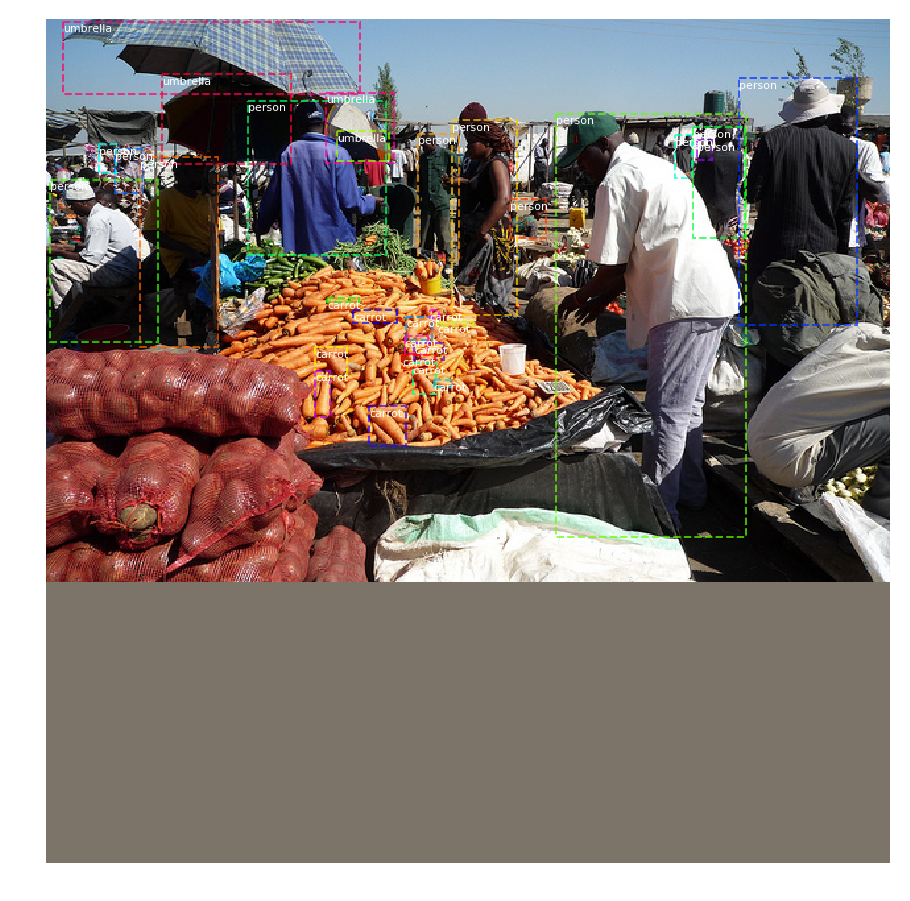

In [5]:
from detection.datasets.utils import get_original_image
img, img_meta, bboxes, labels = train_dataset[0]

rgb_img = np.round(img + img_mean)
ori_img = get_original_image(img, img_meta, img_mean)

visualize.display_instances(rgb_img, bboxes, labels, train_dataset.get_categories())

#### load model

In [6]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

In [7]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

In [8]:
_ = model((batch_imgs, batch_metas), training=False)

In [9]:
model.load_weights('weights/faster_rcnn.h5', by_name=True)

In [10]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)

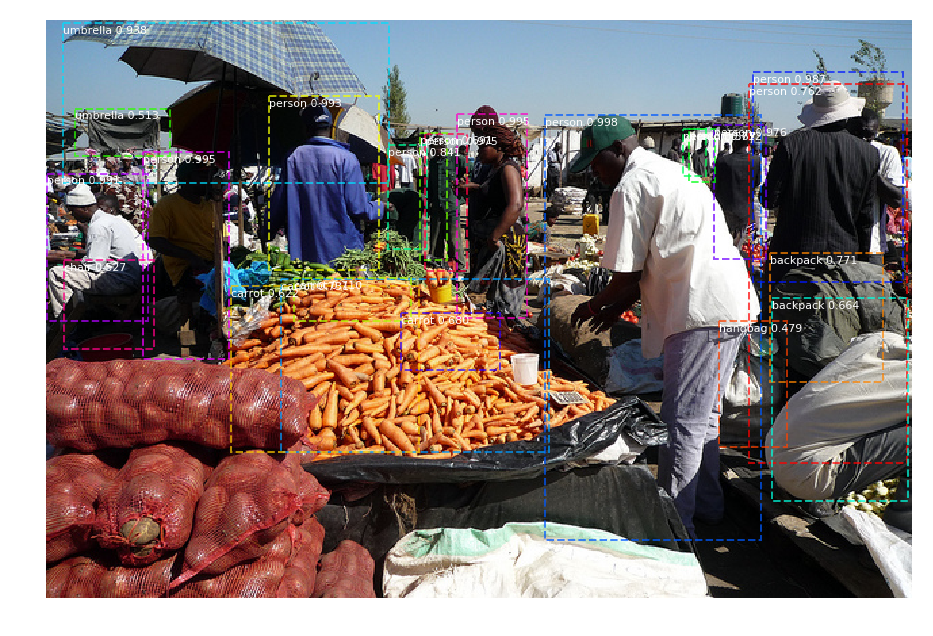

In [11]:
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### use tf.data

In [12]:
batch_size = 1

train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
train_tf_dataset = train_tf_dataset.padded_batch(
    batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))
train_tf_dataset = train_tf_dataset.prefetch(100).shuffle(100)

#### overfit a sample

In [13]:
optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)


batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))
batch_bboxes = tf.Variable(np.expand_dims(bboxes, 0))
batch_labels = tf.Variable(np.expand_dims(labels, 0))

for batch in range(100):
    with tf.GradientTape() as tape:
        rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
            model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

        loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print('batch', batch, '-', loss_value.numpy())

Instructions for updating:
Use tf.identity instead.
batch 0 - 2.0204272
batch 1 - 1.601971
batch 2 - 1.485753
batch 3 - 1.5722116
batch 4 - 1.5858018
batch 5 - 1.4440856
batch 6 - 1.3466835
batch 7 - 1.1918348
batch 8 - 1.1991628
batch 9 - 1.0167909
batch 10 - 0.9433271
batch 11 - 0.91161954
batch 12 - 0.87342477
batch 13 - 0.78296304
batch 14 - 0.80294967
batch 15 - 0.7146708
batch 16 - 0.73202384
batch 17 - 0.69585854
batch 18 - 0.6731874
batch 19 - 0.64792645
batch 20 - 0.50752705
batch 21 - 0.5132008
batch 22 - 0.5627439
batch 23 - 0.4771093
batch 24 - 0.5255151
batch 25 - 0.4711913
batch 26 - 0.45668876
batch 27 - 0.47253186
batch 28 - 0.419168
batch 29 - 0.44158635
batch 30 - 0.4611408
batch 31 - 0.4866392
batch 32 - 0.45466912
batch 33 - 0.45140985
batch 34 - 0.45207512
batch 35 - 0.38849413
batch 36 - 0.4175585
batch 37 - 0.36991018
batch 38 - 0.38976866
batch 39 - 0.3387031
batch 40 - 0.34244382
batch 41 - 0.30845952
batch 42 - 0.29020923
batch 43 - 0.3318683
batch 44 - 0.3173

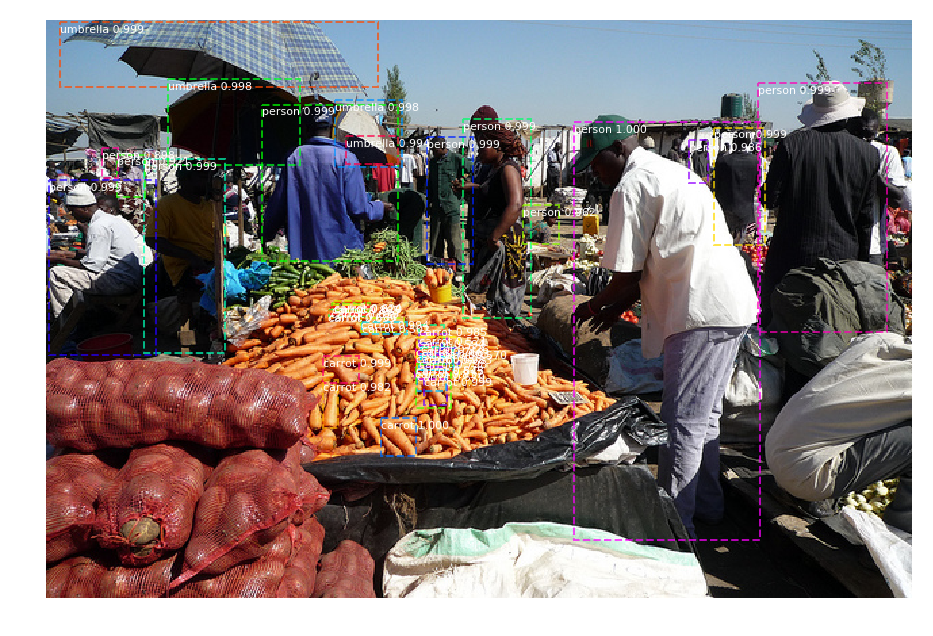

In [14]:
proposals = model.simple_test_rpn(img, img_meta)
res = model.simple_test_bboxes(img, img_meta, proposals)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### train model

In [ ]:
optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)

epochs = 20

for epoch in range(epochs):

    loss_history = []
    for (batch, inputs) in enumerate(train_tf_dataset):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        loss_history.append(loss_value.numpy())
        
        if batch % 100 == 0:
            print('epoch:', epoch, ', batch:', batch, ', loss:', np.mean(loss_history))